In [1]:
# Global imports
import warnings

warnings.filterwarnings("ignore")

import re
import numpy as np
import pandas as pd
import seaborn as sn
# Please install langdetect
from langdetect import detect

from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
food_facts_data = pd.pandas.read_csv('data/en.openfoodfacts.org.products.csv', sep='\t', parse_dates=True, low_memory=False)

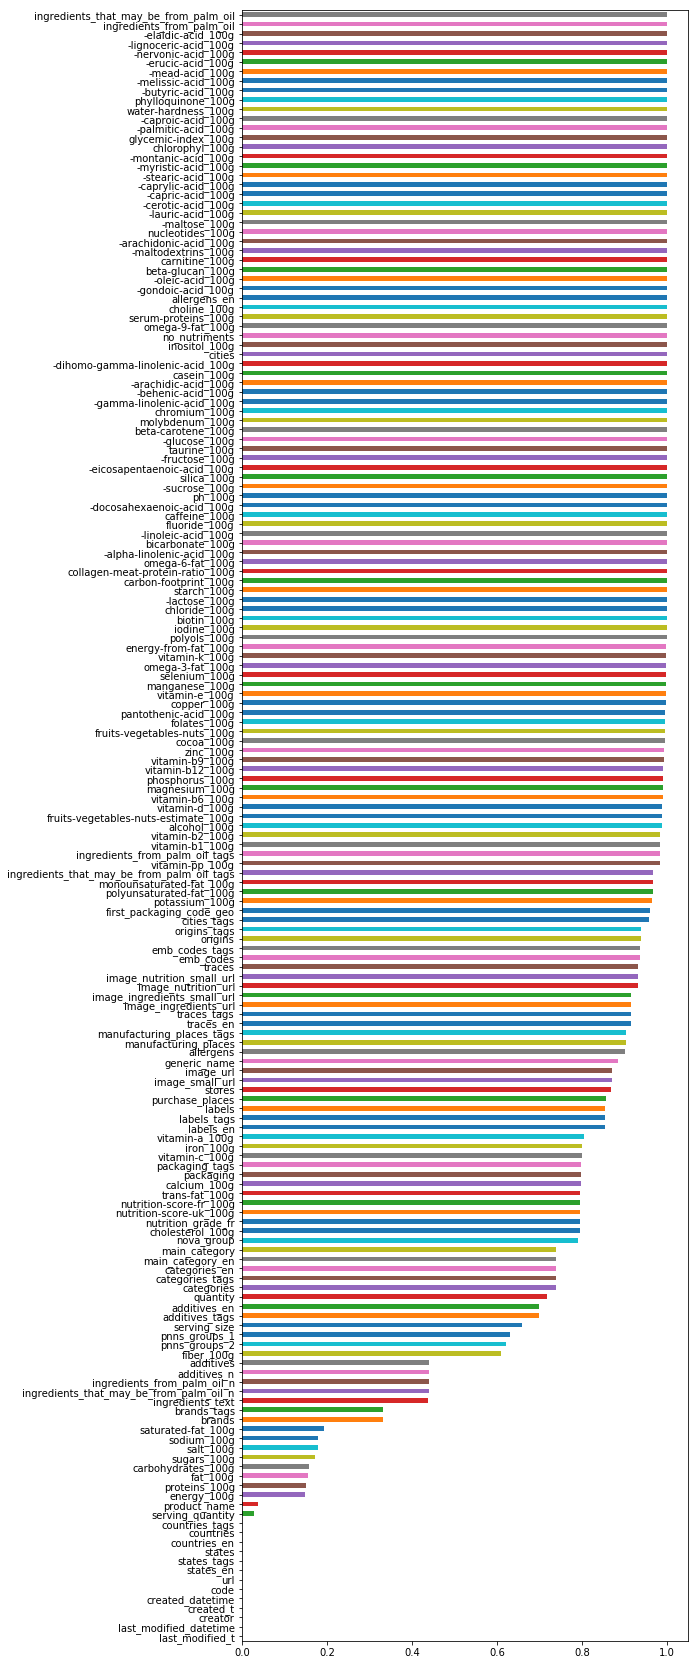

In [3]:
# There are a lot of NaN values in the dataset
food_facts_data.isnull().mean().sort_values(ascending=True).plot.barh(figsize = (8, 30))

### First idea
We are very curious in "Food carbon footprint": greenhouse gas emissions produced by growing, rearing, farming, processing, transporting, storing, cooking and disposing of the food we eat. We are interested in finding out the countries, which are emitting huge amount of carbon in the result of food production and consumption, and identify the ways to reduce it. We hope the dataset will give us insights about the products and their origins having highest carbon footprint(i.e. meat, cheese,eggs, so on) and the ones having lower carbon footprints(i.e. fruit, vegetables, beans, nuts so on). Additionally we consider that food packaging and food waste treatment have huge proportion of impact on carbon emission, thus these were hypothesis that we were interested to test and make conclusions about global problems.

In [4]:
CARBON_FOOD_PRINT_MASK = ~food_facts_data['carbon-footprint_100g'].isnull()
print("Number of food samples with valid carbon foot print is {}".format(food_facts_data[CARBON_FOOD_PRINT_MASK].shape[0]))

Number of food samples with valid carbon foot print is 344


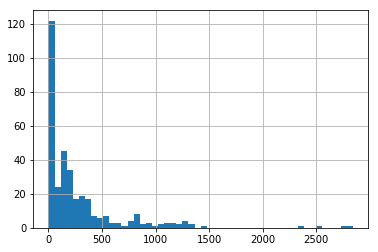

In [5]:
# Distribution of Carbon-foot-print.
food_facts_data['carbon-footprint_100g'].hist(bins=50)

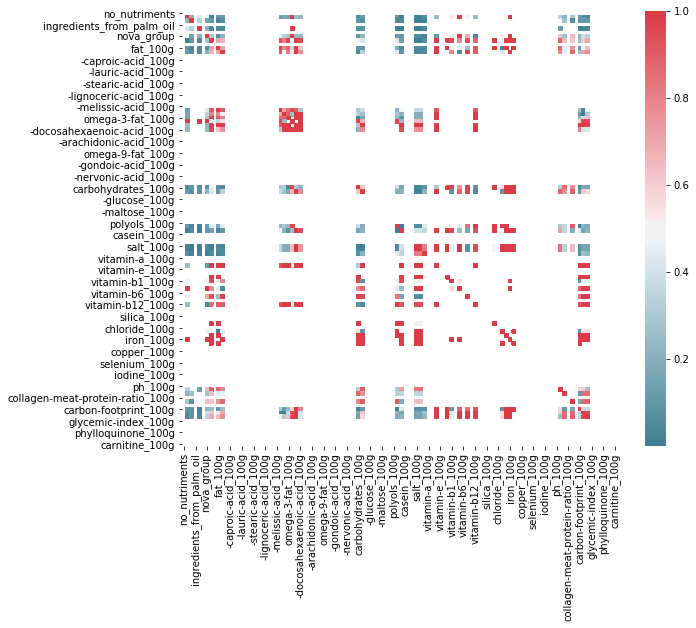

In [6]:
numeric_columns = food_facts_data.dtypes[food_facts_data.dtypes ==  'float64'].index

# Plotting the correlation matrix for carbon food print
corr_ = food_facts_data[CARBON_FOOD_PRINT_MASK][numeric_columns].corr().abs()
fig, axis = plt.subplots(figsize=(10, 8))
sn.heatmap(corr_, mask=np.zeros_like(corr_, dtype=np.bool), cmap=sn.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=axis)

In [7]:
## Sort the features having highest correlation with carbon footprint
valid_corr_columns = corr_['carbon-footprint_100g'].dropna().sort_values(ascending=False)
valid_corr_columns = valid_corr_columns[valid_corr_columns > 0.4]

In [8]:
# Checking out number of data samples with high-correlation with other non-numeric columns.
food_facts_data[food_facts_data['carbon-footprint_100g'].notnull()][valid_corr_columns.index].notnull().sum()

-eicosapentaenoic-acid_100g      5
carbon-footprint_100g          344
vitamin-c_100g                   2
magnesium_100g                   2
iron_100g                        2
phosphorus_100g                  2
vitamin-d_100g                   5
vitamin-b12_100g                 6
vitamin-pp_100g                  3
vitamin-b9_100g                  5
-docosahexaenoic-acid_100g       8
-alpha-linolenic-acid_100g       5
fruits-vegetables-nuts_100g      8
proteins_100g                  295
dtype: int64

## Conclusion

Unfortunately the high correlation is because of the lack of datapoints, it has been shown that the proportions of NAN is very high in the dataset where the carbon footprint has some information. So our thoughts that we may apply regression and other fill in tools to fill the carbon footprint values are ruined, we decided to leave this idea because we dont have enough data and didn't find the carbon footprint of each food product to make real conculsions. 

### Switch to the second idea
 Our final idea is  "Food allergy", which happens when human body overreact to exposure to particular substances in the food.
Our aim in this idea is to identify the possible allergies that unlabeled food may cause and recommend the foods that has specific nutrition  and aren't affecting to people with specific allergies.
The social goodness will be to help food allergic people find their healthy and enough proportion of  food easily.


So we will mostly observe the Additives, Ingredients, Nutrients, Allergens and preprocess them for our next milestone.

## Additives and Nutrients analysis

In [9]:
# Plotting distribution of Additives in the dataset
number_additives = food_facts_data[food_facts_data.additives_en.notnull()].additives_en.str.split(',').values.flatten()
number_additives = np.concatenate(number_additives)
number_additives = np.unique(number_additives, return_counts=True)
number_additives = pd.Series(number_additives[1], index=number_additives[0])

Text(0.5,1,'The top additives in the dataset')

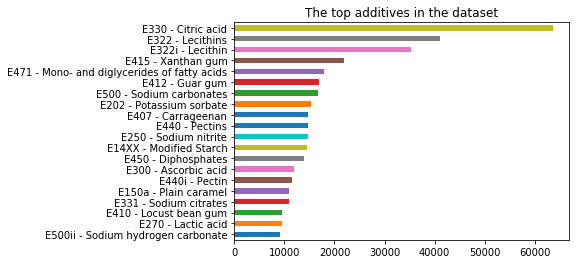

In [10]:
number_additives.sort_values()[-20:].plot.barh()
plt.title("The top additives in the dataset")

In [11]:
print("the number of unique additives in the allergens dataset is {}".format(number_additives.shape[0]))

the number of unique additives in the allergens dataset is 526


According to the documentation of dataset each food item is assigned a unique code. So we can make code as the index of our data frame and relate all the other datasets on this index.

However, we find that the code is not unique.

In [12]:
try:
    food_facts_data.set_index('code', inplace=True, drop=False)
except:
    print('code is already index')
    
print("Is the dataset index unique? {}".format(food_facts_data.index.is_unique))

Is the dataset index unique? False


In [13]:
# Lets investigate the data samples with the same bar code.
_not_unique = food_facts_data[['code']].groupby(food_facts_data.index).count() != 1
food_facts_data.loc[_not_unique[_not_unique.code].index].head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
code,,,,,,,,,,,,,,,,,,,,,
0016000459335,0016000459335,http://world-en.openfoodfacts.org/product/0016...,openfoodfacts-contributors,1483671925,2017-01-06T03:05:25Z,1541702679,2018-11-08T18:44:39Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0016000459335,0016000459335,http://world-en.openfoodfacts.org/product/0016...,openfoodfacts-contributors,1483671925,2017-01-06T03:05:25Z,1541702679,2018-11-08T18:44:39Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0019320001376,0019320001376,http://world-en.openfoodfacts.org/product/0019...,openfoodfacts-contributors,1374110675,2013-07-18T01:24:35Z,1543099200,2018-11-24T22:40:00Z,0.75 oz Nabisco Airplane Cookies - Honey,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0019320001376,0019320001376,http://world-en.openfoodfacts.org/product/0019...,openfoodfacts-contributors,1374110675,2013-07-18T01:24:35Z,1543099200,2018-11-24T22:40:00Z,0.75 oz Nabisco Airplane Cookies - Honey,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0051500006962,0051500006962,http://world-en.openfoodfacts.org/product/0051...,openfoodfacts-contributors,1416251413,2014-11-17T19:10:13Z,1542650866,2018-11-19T18:07:46Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see that the data contains duplicate values for all columns, except for last_modified time. Since the food product is same we pick the latest samples.

In [14]:
food_facts_data.drop(columns=['code'], inplace=True)
food_facts_data = food_facts_data.groupby(food_facts_data.index).head(1)

In [15]:
print("Is index unique: {}".format(food_facts_data.index.is_unique))
print("Number of na index: {}".format(food_facts_data.index.isna().sum()))

Is index unique: True
Number of na index: 1


In [16]:
# Remove the na code food item as the data is corrupted
food_facts_data = food_facts_data.drop(np.nan)

In [17]:
print("Number of na index: {}".format(food_facts_data.index.isna().sum()))

Number of na index: 0


We first analyse the nutritional facts of all the available products. So we keep columns 'product_name', 'categories'
and all nutrition features (number of features: 85)

In [18]:
NUTRIENTS_ALL = [
       'energy_100g', 'energy-from-fat_100g', 'fat_100g',
       'saturated-fat_100g', '-butyric-acid_100g', '-caproic-acid_100g',
       '-caprylic-acid_100g', '-capric-acid_100g', '-lauric-acid_100g',
       '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g',
       '-arachidic-acid_100g', '-behenic-acid_100g',
       '-lignoceric-acid_100g', '-cerotic-acid_100g',
       '-montanic-acid_100g', '-melissic-acid_100g',
       'monounsaturated-fat_100g', 'polyunsaturated-fat_100g',
       'omega-3-fat_100g', '-alpha-linolenic-acid_100g',
       '-eicosapentaenoic-acid_100g', '-docosahexaenoic-acid_100g',
       'omega-6-fat_100g', '-linoleic-acid_100g',
       '-arachidonic-acid_100g', '-gamma-linolenic-acid_100g',
       '-dihomo-gamma-linolenic-acid_100g', 'omega-9-fat_100g',
       '-oleic-acid_100g', '-elaidic-acid_100g', '-gondoic-acid_100g',
       '-mead-acid_100g', '-erucic-acid_100g', '-nervonic-acid_100g',
       'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g',
       'sugars_100g', '-sucrose_100g', '-glucose_100g', '-fructose_100g',
       '-lactose_100g', '-maltose_100g', '-maltodextrins_100g',
       'starch_100g', 'polyols_100g', 'fiber_100g', 'proteins_100g',
       'casein_100g', 'serum-proteins_100g', 'nucleotides_100g',
       'salt_100g', 'sodium_100g', 'alcohol_100g', 'vitamin-a_100g',
       'beta-carotene_100g', 'vitamin-d_100g', 'vitamin-e_100g',
       'vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g',
       'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g',
       'vitamin-b9_100g', 'folates_100g', 'vitamin-b12_100g',
       'biotin_100g', 'pantothenic-acid_100g', 'silica_100g',
       'bicarbonate_100g', 'potassium_100g', 'chloride_100g',
       'calcium_100g', 'phosphorus_100g', 'iron_100g', 'magnesium_100g',
       'zinc_100g', 'copper_100g', 'manganese_100g', 'fluoride_100g',
       'selenium_100g', 'chromium_100g', 'molybdenum_100g', 'iodine_100g',
       'caffeine_100g', 'taurine_100g', 'ph_100g']

In [19]:
nutrition_facts = food_facts_data[NUTRIENTS_ALL]

In [20]:
nutrition_facts.describe()

,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,...,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g
count,6.016780e+05,912.000000,5.963750e+05,5.703070e+05,1.0,1.0,3.000000,3.000000,7.000000,2.00000,...,2213.000000,1732.000000,177.000000,1263.000000,40.000000,41.000000,471.000000,170.000000,59.000000,116.000000
mean,4.818039e+03,561.764572,6.632027e+01,9.538573e+00,5.0,6.0,8.466667,22.360000,35.506390,14.45000,...,0.025035,0.007521,0.007352,0.015115,0.000859,0.000123,0.099419,4.333661,7.906895,6.612463
std,2.823342e+06,701.299208,4.066037e+04,3.151815e+03,NaN,NaN,2.203028,28.267522,21.397063,6.29325,...,0.891949,0.127676,0.046816,0.405908,0.004749,0.000585,1.475740,30.899769,52.122576,1.658754
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,5.0,6.0,7.000000,5.880000,0.044730,10.00000,...,-6.896552,0.000000,0.000000,-0.000002,0.000002,0.000000,0.000000,0.000000,0.000720,0.000000
25%,4.180000e+02,43.800000,5.000000e-01,1.000000e-01,5.0,6.0,7.200000,6.040000,27.000000,12.22500,...,0.000170,0.000000,0.000020,0.000005,0.000010,0.000005,0.000015,0.020000,0.037500,6.087500
50%,1.096000e+03,292.500000,6.350000e+00,1.800000e+00,5.0,6.0,7.400000,6.200000,46.200000,14.45000,...,0.000417,0.001000,0.000100,0.000021,0.000014,0.000007,0.000034,0.032000,0.394000,7.200000
75%,1.674000e+03,879.750000,2.100000e+01,7.350000e+00,5.0,6.0,9.200000,30.600000,49.150000,16.67500,...,0.001000,0.002000,0.000500,0.000054,0.000043,0.000039,0.000090,0.052075,0.400000,7.500000
max,2.190000e+09,3830.000000,3.140000e+07,2.380000e+06,5.0,6.0,11.000000,55.000000,50.000000,18.90000,...,37.600000,4.000000,0.560000,13.900000,0.030000,0.003760,29.000000,333.000000,400.000000,8.400000


We can observe that some nutrients have only very few data points. (For example -butyric-acid has only one data point)
So, we keep only top KEEP_NUTRITION nutrients at the moment so that count is greater than 1000.

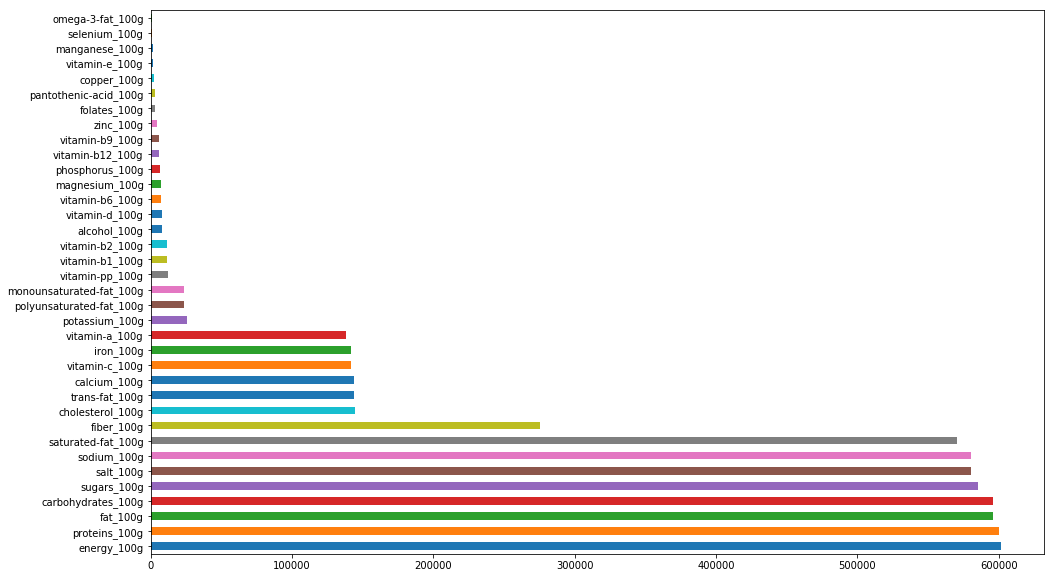

In [21]:
count_nutrition = nutrition_facts.count().sort_values(ascending=False)
count_nutrition = count_nutrition[count_nutrition>1000.]
count_nutrition.plot.barh(figsize=(16,10))

In [22]:
NUTRIENTS_FEATURES = count_nutrition.index.values.tolist()
# Now we have 36 nutrients columns.
# 'energy_100g', 'proteins_100g', 'fat_100g', 'carbohydrates_100g', 'sugars_100g', 'salt_100g', 'sodium_100g',
# 'saturated-fat_100g', 'fiber_100g', 'cholesterol_100g', 'trans-fat_100g', 'calcium_100g', 'vitamin-c_100g', 'iron_100g',
# 'vitamin-a_100g', 'potassium_100g', 'polyunsaturated-fat_100g', 'monounsaturated-fat_100g', 'vitamin-pp_100g', 
# 'vitamin-b1_100g', 'vitamin-b2_100g', 'alcohol_100g', 'vitamin-d_100g', 'vitamin-b6_100g', 'magnesium_100g', 'phosphorus_100g',
# 'vitamin-b12_100g', 'vitamin-b9_100g', 'zinc_100g', 'folates_100g', 'pantothenic-acid_100g', 'copper_100g', 'vitamin-e_100g',
# 'manganese_100g', 'selenium_100g', 'omega-3-fat_100g'

In [23]:
nutrition_facts = nutrition_facts[NUTRIENTS_FEATURES]

In [24]:
nutrition_facts.describe()

,energy_100g,proteins_100g,fat_100g,carbohydrates_100g,sugars_100g,salt_100g,sodium_100g,saturated-fat_100g,fiber_100g,cholesterol_100g,...,vitamin-b12_100g,vitamin-b9_100g,zinc_100g,folates_100g,pantothenic-acid_100g,copper_100g,vitamin-e_100g,manganese_100g,selenium_100g,omega-3-fat_100g
count,6.016780e+05,6.002070e+05,5.963750e+05,5.961210e+05,585573.000000,5.805090e+05,580474.000000,5.703070e+05,2.754620e+05,144638.000000,...,5.888000e+03,5713.000000,4279.000000,3066.000000,2770.000000,2213.000000,1952.000000,1732.000000,1263.000000,1256.000000
mean,4.818039e+03,2.091020e+01,6.632027e+01,1.117784e+02,16.600878,5.239080e+00,2.060981,9.538573e+00,2.025893e+04,0.024564,...,1.468781e-03,0.010377,0.017572,0.204245,0.055031,0.025035,0.186374,0.007521,0.015115,4.366503
std,2.823342e+06,9.835878e+03,4.066037e+04,6.229917e+04,651.573565,1.890538e+03,743.032565,3.151815e+03,1.061268e+07,0.681383,...,4.532108e-02,0.403973,0.263589,5.112149,1.382715,0.891949,2.620545,0.127676,0.405908,19.352881
min,0.000000e+00,-8.000000e+02,0.000000e+00,0.000000e+00,-17.860000,0.000000e+00,0.000000,0.000000e+00,-2.000000e+01,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-6.896552,0.000000,0.000000,-0.000002,0.000000
25%,4.180000e+02,1.000000e+00,5.000000e-01,3.900000e+00,0.800000,6.600000e-02,0.026000,1.000000e-01,0.000000e+00,0.000000,...,6.300000e-07,0.000030,0.001200,0.000042,0.000465,0.000170,0.001800,0.000000,0.000005,0.500000
50%,1.096000e+03,5.400000e+00,6.350000e+00,1.667000e+01,4.350000,5.410200e-01,0.213000,1.800000e+00,1.500000e+00,0.000000,...,1.800000e-06,0.000052,0.003490,0.000114,0.001692,0.000417,0.005300,0.001000,0.000021,1.800000
75%,1.674000e+03,1.100000e+01,2.100000e+01,5.500000e+01,21.760000,1.353820e+00,0.533000,7.350000e+00,3.600000e+00,0.020000,...,4.512500e-06,0.000084,0.007500,0.000214,0.004167,0.001000,0.012700,0.002000,0.000054,3.300000
max,2.190000e+09,7.620000e+06,3.140000e+07,4.810000e+07,476000.000000,1.430000e+06,562000.000000,2.380000e+06,5.570000e+09,127.000000,...,2.100000e+00,23.076923,10.500000,178.571429,60.000000,37.600000,90.000000,4.000000,13.900000,485.000000


We also observe many outliers in the dataset. For example, for some products proteins_100g value is 31000 which should not be
possible as we are measuring the quantities in per 100 g. One possible explaination would be that the units of measurements
are not consistent with other samples. Also, some nutrients values are negative. These values may be as a result of error in
interpreting - sign as negative.
Presently, we remove these outliers from the data.

In [25]:
def remove_outliers(df):
    # First remove the negative sign
    df = df.abs()
    
    # As the weight of the food item is 100g, the weight of nutrients can never exceed 100g.
    threshold_cutoff = pd.Series(100*np.ones(df.columns.size), index=df.columns)
    
    # Since energy_100g measured in kilo joules(kJ) we don't clip it. However the highest energy is given by fats (37kJ/g).
    # So the upper bound of energy per 100g should be 3700kJ.
    threshold_cutoff.loc['energy_100g'] = 40*1e2
    
    return df[df <= threshold_cutoff].dropna(how='all')

In [26]:
nutrition_facts_filt = remove_outliers(nutrition_facts)
print("Nutrition data shape {}".format(nutrition_facts_filt.shape))

Nutrition data shape (607257, 36)


In [27]:
nutrition_facts_filt.describe()

,energy_100g,proteins_100g,fat_100g,carbohydrates_100g,sugars_100g,salt_100g,sodium_100g,saturated-fat_100g,fiber_100g,cholesterol_100g,...,vitamin-b12_100g,vitamin-b9_100g,zinc_100g,folates_100g,pantothenic-acid_100g,copper_100g,vitamin-e_100g,manganese_100g,selenium_100g,omega-3-fat_100g
count,600791.000000,600138.000000,596287.000000,595940.000000,585446.000000,580049.000000,580213.000000,570258.000000,275401.000000,144637.000000,...,5.888000e+03,5713.000000,4279.000000,3063.000000,2770.000000,2213.000000,1952.000000,1732.000000,1263.000000,1250.000000
mean,1130.218990,7.913230,13.271533,29.276667,14.745216,1.477018,0.599299,5.169841,2.928388,0.023686,...,1.468781e-03,0.010377,0.017572,0.052867,0.055031,0.031268,0.186374,0.007521,0.015115,3.238662
std,792.966588,9.242618,17.417222,28.535527,20.639019,5.806223,2.496753,7.886296,4.979170,0.593982,...,4.532108e-02,0.403973,0.263589,1.443741,1.382715,0.891752,2.620545,0.127676,0.405908,5.988401
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,418.000000,1.000000,0.500000,3.900000,0.800000,0.064000,0.025591,0.100000,0.000000,0.000000,...,6.300000e-07,0.000030,0.001200,0.000042,0.000465,0.000174,0.001800,0.000000,0.000005,0.500000
50%,1096.000000,5.400000,6.340000,16.670000,4.350000,0.540000,0.212598,1.800000,1.500000,0.000000,...,1.800000e-06,0.000052,0.003490,0.000114,0.001692,0.000417,0.005300,0.001000,0.000021,1.800000
75%,1674.000000,11.000000,21.000000,55.000000,21.700000,1.350000,0.531496,7.350000,3.600000,0.020000,...,4.512500e-06,0.000084,0.007500,0.000214,0.004167,0.001000,0.012700,0.002000,0.000054,3.300000
max,4000.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,97.900000,...,2.100000e+00,23.076923,10.500000,57.142857,60.000000,37.600000,90.000000,4.000000,13.900000,68.000000


In [28]:
def plot_distributions_nutrition(df, nlog_scale_col):
    fig, axes = plt.subplots(9, len(df.columns)//9, figsize=(30, 30))
    axes = axes.flatten()
    for col, axis in zip(df.columns, axes):
        bins = np.linspace(df[col].min(), df[col].quantile(0.99), 50)
        df.hist(column = col, bins = bins, ax=axis)
        if not col in nlog_scale_col:
            axis.set_yscale('log')

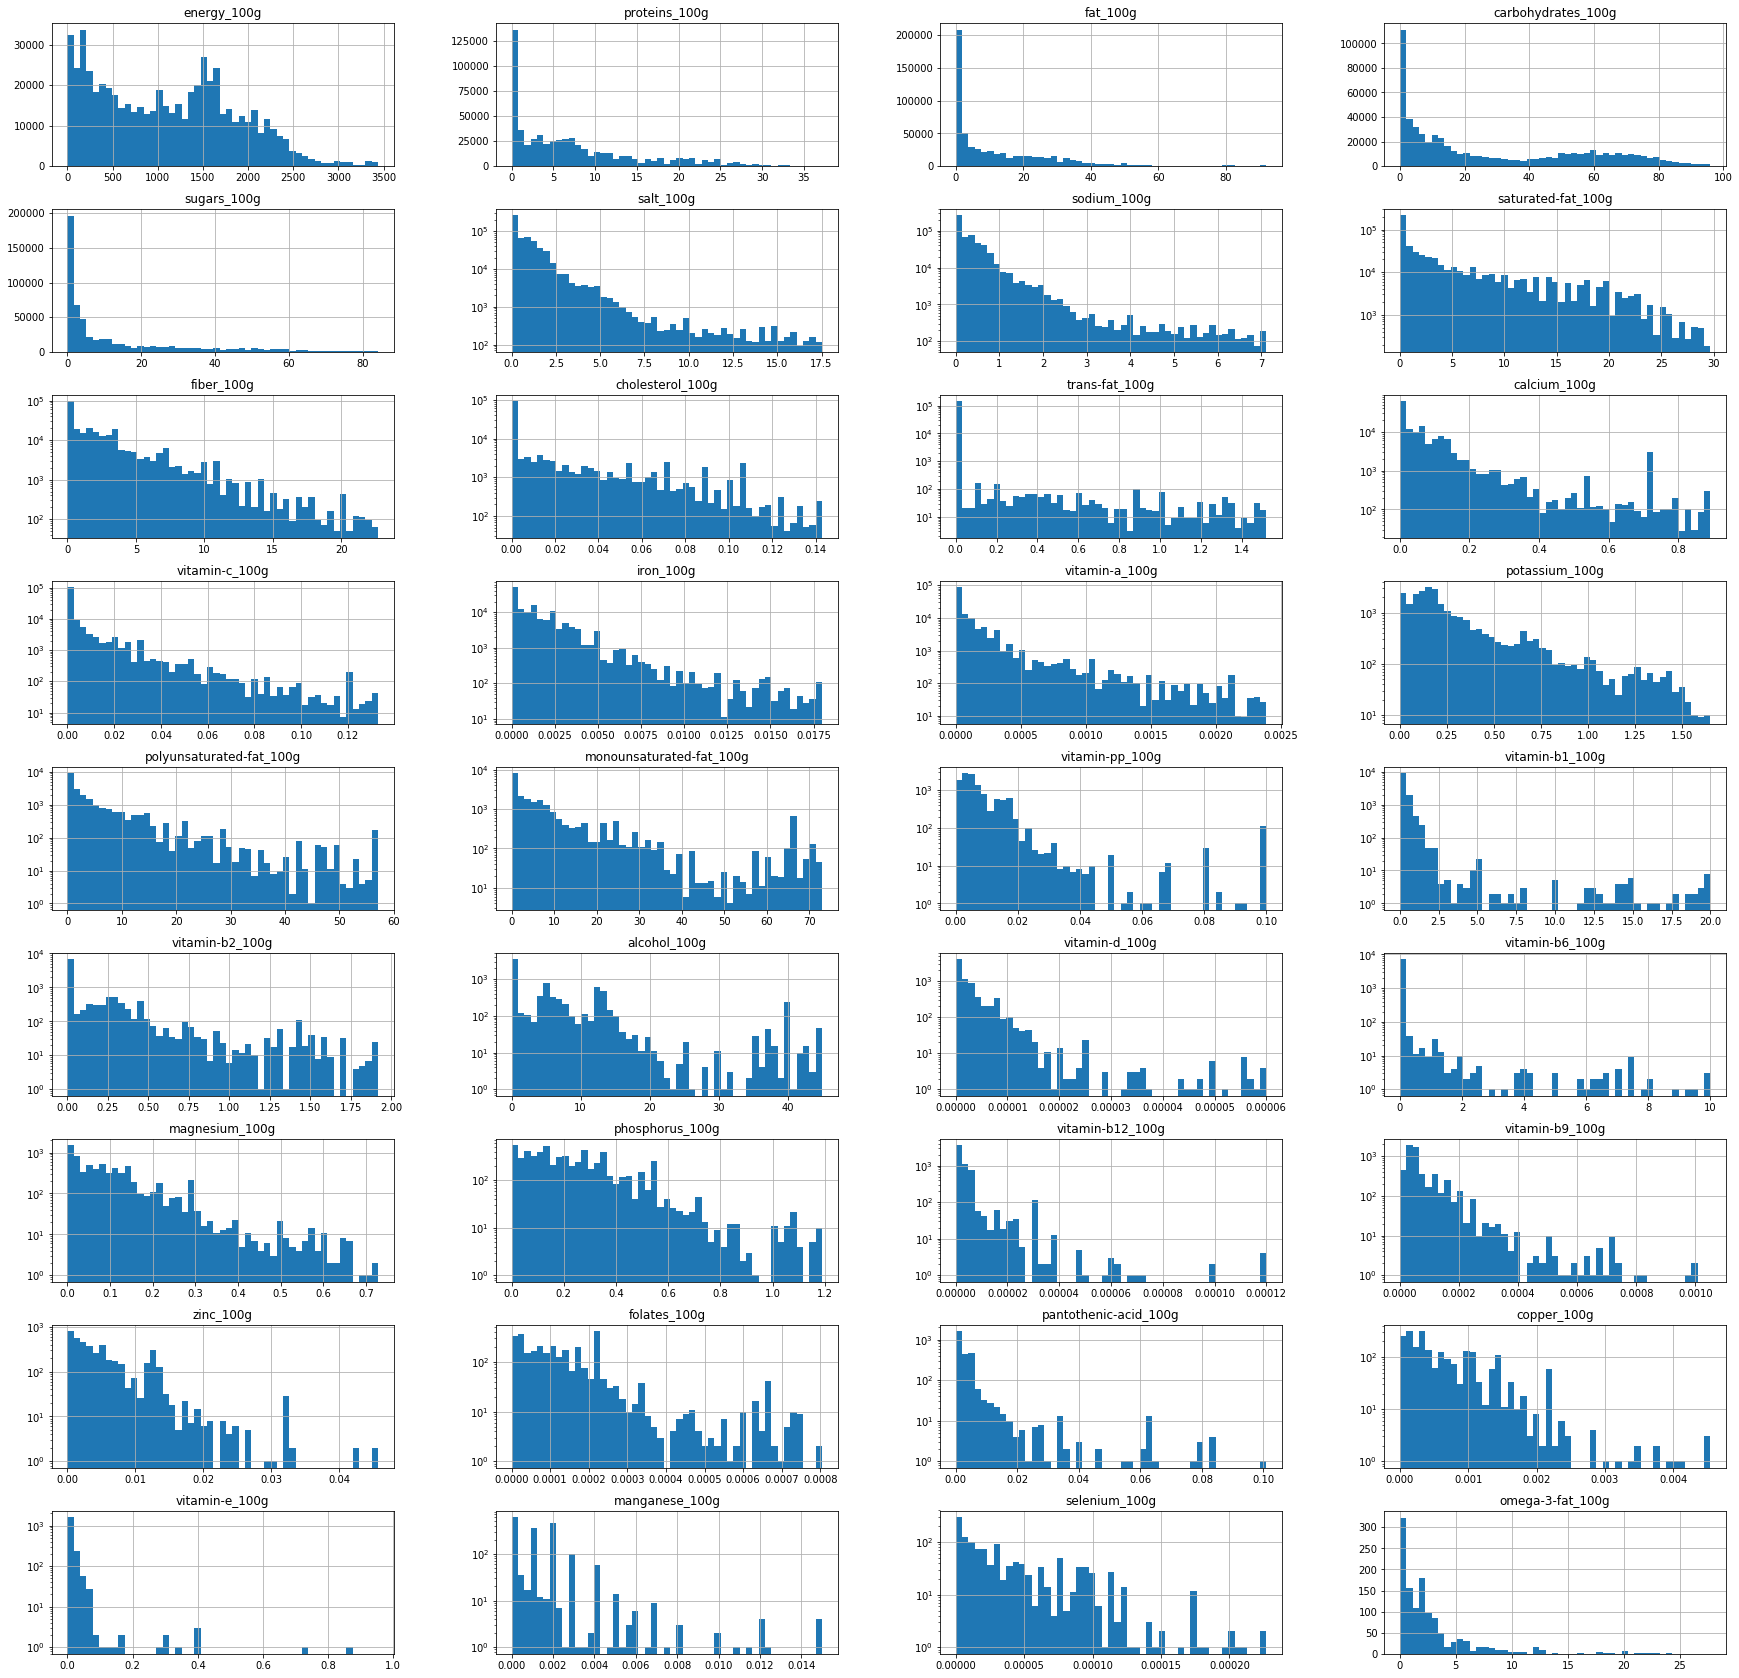

In [29]:
plot_distributions_nutrition(nutrition_facts_filt, nlog_scale_col=['energy_100g', 'proteins_100g', 'fat_100g',
                                                                  'carbohydrates_100g', 'sugars_100g', 
                                                                   'omega-3-fat_100g'])

If a nutrition value is not mentioned on the label (NaN), we can assume that the nutrient is absent in the food item.
Thus we replace all NaN with 0. This is because in the absence of any nutrition value, we have no way to know if the product
actually has that nutrient. For the outlier products, our proposed solution of recommending alternate food product
based on nutrients (for allergies and additives) can give wrong results. But we see that this problem even arises with OpenFood
website that calcultes nutri-score wrong if outliers are present.



In [30]:
def remove_nan_values(df):
    df[df.columns.drop('energy_100g')] = df[df.columns.drop('energy_100g')].replace(np.NaN, 0)
    return df

nutrition_facts_filt = remove_nan_values(nutrition_facts_filt)

In [31]:
print("The shape of nutrition data after missing values removal {}".format(nutrition_facts_filt[nutrition_facts_filt.energy_100g.isna()].shape))

The shape of nutrition data after missing values removal (6466, 36)


We Observe that there are 6424 products with unknown energy_100g. 
So, for these products we can calculate approximate energy.


$${energy{100g}} = 17*{protein{100g}} + 37*{fat{100g}} + 17*{carbohydrate{100g}} + 8*{fibre{100g}} + 29*{alcohol_{100g}}$$


source: http://www.mydailyintake.net/energy/

In [32]:
def remove_energy_nan(df):
    na_mask = df['energy_100g'].isna()
    df.loc[df.index[na_mask], 'energy_100g'] = \
                        17*(df[na_mask].proteins_100g + df[na_mask].carbohydrates_100g) +\
                        37*df[na_mask].fat_100g + 8*df[na_mask].fiber_100g + 29*df[na_mask].alcohol_100g
    return df

In [33]:
nutrition_facts_filt = remove_energy_nan(nutrition_facts_filt)

In [34]:
food_facts_data.drop(NUTRIENTS_ALL, axis = 1, inplace = True)

In [35]:
# put all the changes to the original data
food_facts_data = food_facts_data.merge(nutrition_facts_filt, left_index=True, right_index=True)

## Text exploration

Now lets do some research on how ingredients text and allergens are like and what transformation do we need to perform for each one of them

In [36]:
# Getting all the data where ingredients text and allergens are applicable
food_allergens_mask = food_facts_data["ingredients_text"].notnull() & food_facts_data["allergens"].notnull()
food_allergens = food_facts_data[food_allergens_mask]

In [37]:
print("The total number of products is: {}".format(food_facts_data.shape[0]))
print("The total number of products with food allergens ando ingredients data is: {}".format(food_allergens.shape[0]))

The total number of products is: 607257
The total number of products with food allergens ando ingredients data is: 66754


****This is approximately 10% of the dataset and hence we have more training data then carbon footprint****

In [38]:
# Get the language for a particular food / allergen product - as to which language is it written in
def detect_language(phrase):
    try:        
        if not phrase:
            return 'No language'
        
        language_id = detect(phrase)
        return language_id
    except:
        pass

In [39]:
food_allergens['language_id'] = food_allergens["ingredients_text"][:2000].apply(lambda x: detect_language(x))

So we take the first 2000 samples to see how many languages are there
As, we can see there are 22 languages for ingredients_text which is a ***very difficult translation task in its own!***

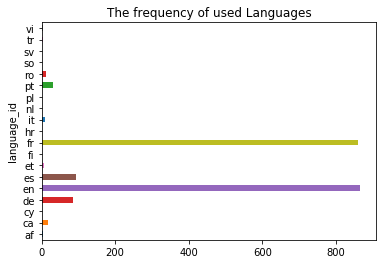

In [40]:
food_allergens.groupby('language_id').count()['url'].plot.barh()
plt.title("The frequency of used Languages")
food_allergens = food_allergens.drop(columns=["language_id"])

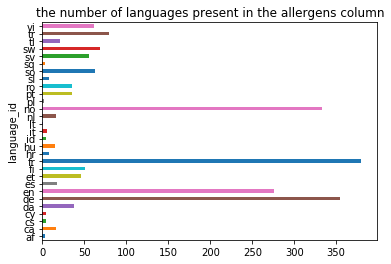

In [41]:
# Now trying to find the number of languages present in the allergens column
food_allergens['language_id'] = food_allergens["allergens"][:2000].apply(lambda x: detect_language(x))
food_allergens.groupby('language_id').count()['url'].plot.barh()
plt.title("the number of languages present in the allergens column")
food_allergens = food_allergens.drop(columns=["language_id"])

In [42]:
allergens_dict = {}
with open("original_allergens.txt") as f, open("english_allergens.txt") as f2:
    for x, y in zip(f, f2):
        allergens_dict[x.lower().replace('\n', '').strip().rstrip()] = re.sub(' +', ' ', y).lower().replace('\n', '').strip().rstrip()

In [43]:
def split_string_to_list(phrase, match_dict=None):
    # Sometimes the word has a incorrect language tag in front of it
    # So we are removing all tags and using language detection instead
    foods = []

    for food in phrase.split(','):
        food = food.strip().rstrip()
        
        # Delete all additives since additives are nearly defined for the whole dataset
        food = re.sub(' +', ' ', food).lower()
        food = re.sub(r"[^A-Za-zàâçéèêëîïôûùüÿñæœ\'\s,]", '', food)
        
        # or food items which are made up of one characters
        if(len(food) <= 2):
            continue
        
        # Split the tag - en, fr if they have it
        formatted_food = food.split(':')[1] if ':' in food else food
    
        if match_dict and formatted_food in match_dict:
            translated_food = match_dict[formatted_food]
        else:
            translated_food = formatted_food
        foods.append(translated_food)
    return foods

Transferring all french allergens or allergens in any other language to the english language from the translated files we have

In [44]:
food_allergens['allergens'] = food_allergens['allergens'].apply((lambda x: split_string_to_list(x, match_dict=allergens_dict)))

In [45]:
food_allergens['allergens'] = food_allergens['allergens'].apply(frozenset) # Removing all the duplicates from each of the product
unique_allergens = frozenset.union(*food_allergens['allergens'])

print("The total number of food allergens before cleaning them for less than 5 products: {}".format(len(unique_allergens)))

The total number of food allergens before cleaning them for less than 5 products: 1982


In [46]:
# Now we get the allergy count for each of the allergies which are present in more than 5 products
allergen_count = {}
temp_allergens = list(unique_allergens)

# Calculating the allergens and removing the allergens which are present in less than 5 products
for allergen in unique_allergens:
    count = food_allergens['allergens'].apply(lambda x: int(allergen in x)).sum()
    
    # Remove allergen if it is present in less than 5 products
    if count < 5:
        temp_allergens.remove(allergen)
        continue
    allergen_count[allergen] = count

In [ ]:
pd.Series(allergen_count).sort_values()[-20:].plot.barh() 
plt.title("top most 20 allergens in the dataset")

In [ ]:
print('Total number of allergens after cleaning them by considering them for greater than 5 products: {}'.format(
    len(allergen_count.keys())))

In [ ]:
# Take the intersection of all allergens which coexist with 
allergen_set = frozenset(allergen_count.keys())
food_allergens['allergens'] = food_allergens['allergens'].apply(lambda x: allergen_set.intersection(x))

In [ ]:
temp_allergens_df = pd.DataFrame(pd.np.empty((food_allergens.shape[0],len(allergen_set))) * 0, columns=allergen_count.keys(), index=food_allergens.index) 

In [ ]:
food_allergens['allergens'] = food_allergens.allergens.apply(list)

In [ ]:
# Making one hot encoding labels for each of the allergen we need to consider in the dataset
for index in food_allergens.index:
    temp_allergens_df.loc[index, food_allergens.loc[index].allergens] = 1

In [ ]:
food_allergens = pd.concat([food_allergens, temp_allergens_df], axis=1)

In [ ]:
food_allergens.head() # we can see that dummy features have been added at the end of the dataset

In [ ]:
# Splitting and flattening the ingredients text to see how many unique ingredients are there in  the total dataset
food_allergens['ingredients_text'] = food_allergens['ingredients_text'].apply((lambda x: split_string_to_list(x)))
food_allergens['ingredients_text'] = food_allergens['ingredients_text'].apply(frozenset)

# Removing all the duplicates from each of the product
unique_ingredients = frozenset.union(*food_allergens['ingredients_text'])

print("The total number of unique ingredients in the dataset are: {}".format(len(unique_ingredients)))

Since, there are 186516 features which are 60 times more than the number of unique allergens (approx 3000). We will need to group these ingredients together under the same umbrella. For this, we are going to go through each of the unique ingredients datasets and get only nouns out from them, and then use word2vec and nltk libraries to group similar ingredients under the higher level ingredient. 

We haven't pursued this task since for this we would need to train a model on all ingredients and this comes under feature engineering and modelling aspect which we will pursue for Milestone 3.
Google translate was used to translate the text feature files, hence the translations are not accurate since they contained several languages, which makes the automatic translation task be difficult.

In [ ]:
# drop the features which are not needed
food_facts_data.drop(['url','image_url', 'image_small_url',
       'image_ingredients_url', 'image_ingredients_small_url',
       'image_nutrition_url', 'image_nutrition_small_url',
        'created_t','last_modified_t', 'generic_name','packaging_tags',
        'manufacturing_places_tags','emb_codes', 'emb_codes_tags','first_packaging_code_geo',
        'cities_tags','countries_tags','no_nutriments', 'additives_tags','cities','ingredients_from_palm_oil',
        'ingredients_that_may_be_from_palm_oil','nutrition_grade_uk', 'nova_group','energy_100g'],
         axis = 1, inplace = True)

In [ ]:
# Save the data as csv file
food_facts_data.to_csv('food_facts.csv')
food_allergens.to_csv('food_allergens.csv')

### We end Milestone 2 here. From here, onwards we follow up with Milestone and the research questions mentioned in the README.

# Feature Engineering - Allergens

In this part of the notebook, we are going to group the allergens into a small categories so that we can be more specific as to how each product has what kind of allergen. The allergens were translated before using Google translate and some manual data cleaning, although it was kind of tedious job since allergens or the text in general is in many languages in the dataset.

For example: milk, milk solids would come under the `milk` related allergen.

In [47]:
## Putting in the imports for Milestone 3
import os
import re
import nltk
import itertools
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE
from collections import Counter
from nltk.stem import PorterStemmer
from gensim.models import KeyedVectors
from nltk.cluster import KMeansClusterer
from gensim.scripts.glove2word2vec import glove2word2vec

In [48]:
## Loading the file with all the translated allergens
translated_words = []

with open('./english_allergens.txt') as f:
    for line in f.readlines():
        translated_words.append(line)

In [49]:
print('Total number of english translated allergens: {}'.format(len(translated_words)))

Total number of english translated allergens: 3171


We are converting each of the translated allergens into lowercase for consistency, stripping any allergens which are completely made up of numbers, stripping them of spaces and some of the allergens have question marks and other characters and cleaning them as well.

In [50]:
# Do a bit of data cleaning on the allergens to make them more consistent
translated_words = [word.lower() for word in translated_words]
translated_words = [re.sub(r'\b[0-9]+\b\s*', '', word).strip().rstrip() for word in translated_words]
translated_words = [word.replace('?', '').replace('-', ' ').replace("'", '') for word in translated_words]

In [51]:
# Check how many allergens are single words
total_single_words = 0
for word in translated_words:
    if len(word.split(' ')) != 1:
        continue
    else:
        total_single_words += 1
        
print('Total number of allergens which are single word: {}'.format(total_single_words))

Total number of allergens which are single word: 1514


Now from above, we know that out of 3168 allergens; about 1517 allergens are single words. So they can be easily fed into the `Word2Vec` model, but we need to take care of the allergens which are **made up of 2 or more words**. 

Below, we try to remove the duplicates since many of the translated allergens end up being translated to the same context.

In [52]:
single_words = {}
for word in translated_words:
    single_words[word] = word.split(' ')

cnt_single_words = Counter(list(itertools.chain(*single_words.values())))

Now we use the NLTK library for Part of Speech tagging since we are only interested in Nouns and not verbs, adjectives etc. So, we tag each word according to what category it belongs to and remove the ones which are not nouns. Also, consider only words which are made up of characters not empty strings.

In [53]:
# Using the NLTK library for Part of Speech tagging
for word in single_words:
    if not word:
        continue
    single_words[word] = [w for w in single_words[word] if w]
    single_words[word] = nltk.pos_tag(single_words[word])

In [54]:
for word in single_words:
    result = []
    if not any(single_words[word]):
        single_words[word] = result
    else:
        for w, tag in single_words[word]:
            if tag.startswith('NN') or tag.startswith('JJ'):
                result.append((w, tag))
            single_words[word] = result

Now we know that some of the allergens are actually additives and these additives generally have a format in which they are written in. For example, `e223`, we remove all of these entries from the dictionary and put them in a list which is labelled for additives.

In [55]:
all_additives = []

for word in single_words.copy():
    if not bool(re.match(r"e[0-9]{3}", word)):
        continue
    else:
        all_additives.append(word)
        del single_words[word]

We can also remove entries from the dictionary which are of length 1 or 2, since they do not make any sense and hence would be easier for the Word2Vec model to train without noise.

In [56]:
# remove allergens which are of single length or length 2
for word in single_words.copy():
    if len(word) > 2 and single_words[word]:
        continue
    else:
        del single_words[word]

Now we load the pre existing word2Vec model which has been trained by GLoVE and load it. This has been primarily been trained on Wikipedia dataset and news articles. We will use this model to generate the vector for each of our allergens.

In [57]:
word2vec_output_file = 'data/word2vec_pretrained.txt'

# Only change the glove file to word2vec file if it does not exist
if not os.path.exists('data/word2vec_pretrained.txt'):
    glove2word2vec('data/glove.840B.300d.txt', word2vec_output_file)

model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
print('Number of vocab unique words: {}'.format(len(model.wv.vocab.items())))

Number of vocab unique words: 2196016


For each of the words which have vectors, we load the vector from the model otherwise we append them to the others list since these are words not present in the model and the `Others` tag can be associated with them.

In [58]:
## Getting the word embeddings for each of the unique words present
other_words = []

total_words = []
for word in single_words:
    total_words.extend(word.split(' '))
total_words = set(total_words)

word_embedding_matrix = dict()
for word in total_words:
    try:
        word_embedding_matrix[word] = model.wv.__getitem__(word)
    except KeyError:
        other_words.append(word)
        pass

Now all the Word2Vec vectors are in 300 dimensions. To visualize them, we need to reduce them to 2 dimensions and see what clusters are made up of them. For this, we use the algorithm called `TSNE`. This basically clusters based on the distance and taking in account the local and global context of the vectors.

In [59]:
def tsne_plot(model):
    labels = []
    tokens = []

    for word in word_embedding_matrix:
        tokens.append(word_embedding_matrix[word])
        labels.append(word)
    
    # Perplexity takes into account the global and local features
    # We are using dimensionality reduciton for 2 features and taking 2500 iterations into account
    tsne_model = TSNE(perplexity=40, n_components=2, n_iter=2500, random_state=0)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

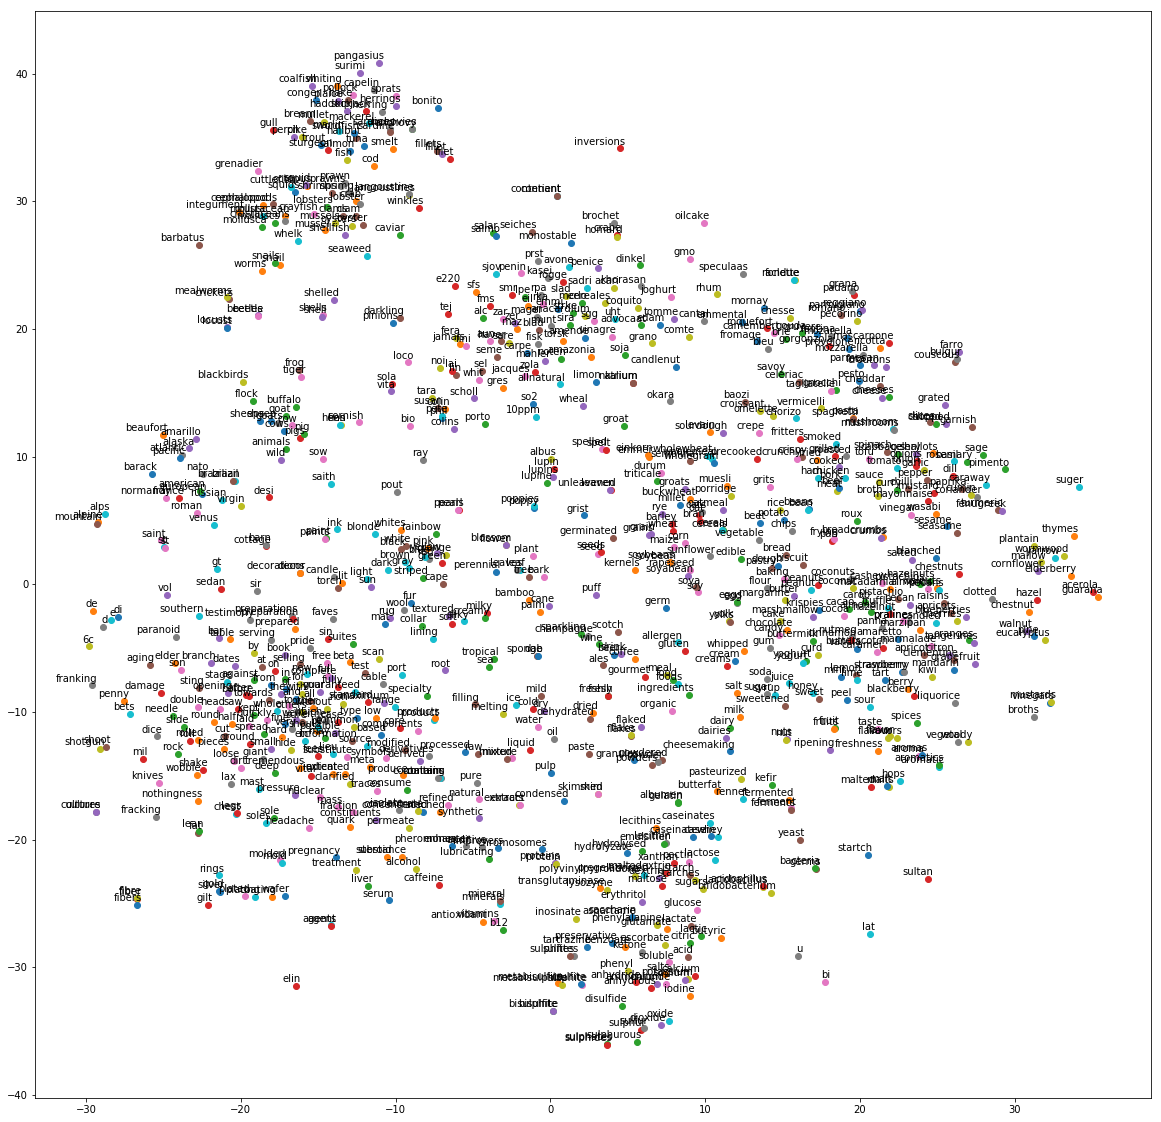

In [60]:
tsne_plot(model)

As we can see from above, our Word2Vec works, a really interesting result!.  This can be seen that the chemicals are grouped together on the bottom right, the seafood are grouped together in the upper center of the graph, and we can also see examples that `dehydrated` and `dried` go together, `scotch`, `beer`, `ales` are also grouped together. Hence, our Word2Vec is able to group words of the same context together.

In [61]:
temp_single_words = single_words.copy()
others_present_in_single = []

for word in temp_single_words:
    for w, t in temp_single_words[word]:
        if not w in other_words:
            continue
        else:
            if len(single_words[word]) == 1:
                del single_words[word]
            else:
                others_present_in_single.append(w)
                single_words[word] = [(i, tag) for i, tag in single_words[word] if w != i]

In [62]:
other_words = set(other_words) - set(others_present_in_single)

In [63]:
for word in single_words:
    single_words[word] = [(w, t, word_embedding_matrix[w]) for w, t in single_words[word]]

In [64]:
allergens_embedding_matrix = dict()

for word in single_words:
    allergens_embedding_matrix[word] = sum([e for w, t, e in single_words[word]])

Now, although we have Word2Vec vectors and they have been clustered correctly on the basis of context. We would like to cluster these words in the allergens together on the basis of `similarity` (cosine similarity metric). For this, we use the K Means clustering algorithm with with cosine as the distance metric. Once, we have assigned them to clusters we assign each of the labels to each word so that we can relate them.

In [65]:
total_clusters = 5
# Applying Kmeans clusters on vectors  and making 10 clusters out of it
k_means = KMeansClusterer(total_clusters, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = k_means.cluster(allergens_embedding_matrix.values(), assign_clusters=True)
print(assigned_clusters[:20])

[1, 1, 1, 1, 2, 3, 0, 2, 2, 1, 1, 2, 1, 1, 1, 0, 4, 2, 1, 2]


In [66]:
assigned_cluster_dict = dict()
for i, word in enumerate(allergens_embedding_matrix.keys()):  
    assigned_cluster_dict[word] =  assigned_clusters[i]
    
# Add additives and others to assigned cluster dict
assigned_cluster_dict.update(dict.fromkeys(all_additives, 5))
assigned_cluster_dict.update(dict.fromkeys(other_words, 6))

In [67]:
# Change the labels for each cluster and assign labels to it
assigned_labels = pd.DataFrame.from_dict(assigned_cluster_dict, orient='index')
assigned_labels.head()

,0
butter,1
oranges,1
freenfield yellow seeds,1
egg,1
whey powder,2


So, as we have done clustering on each of the allergens and classified them into 7 categories.

0. This contains all kind of `wheat`, `flour`
1. Mostly milk, fruit and nut related products like `butter`, `orange`, `egg`
2. Mostly powdered related products `whey powder` or related to proteins - like `milk protein`, `whey protein`
3. All kinds of acids - like `bisulfite`, `lactate`, `lupine`
4. Mostly sea food related allergens - such as `shellfish`, `capelin`
5. Additives
6. Others - which we have been unable to translate or which not present in the Word2Vec vocab.

In [68]:
labels = {
    0: 'wheat/flour', 1: 'milk/fruit/nut', 2: 'powder/protein',
    3: 'acids', 4: 'seafood', 5: 'additives', 6: 'others'
}

# Assigning the grouped labels we found each
assigned_labels['grouped'] = assigned_labels[0].apply(lambda x: labels[x])
assigned_labels.head()

,0,grouped
butter,1,milk/fruit/nut
oranges,1,milk/fruit/nut
freenfield yellow seeds,1,milk/fruit/nut
egg,1,milk/fruit/nut
whey powder,2,powder/protein


In [74]:
def get_grouped_labels(x):
    result = []
    for i in x:
        if i not in assigned_labels.index:
            continue
        else:
            result.append(assigned_labels[assigned_labels.index == i].values[0][1])
    return result

# Assigned grouped allergens
food_allergens['grouped_allergens'] = food_allergens['allergens'].apply(lambda x: get_grouped_labels(x))

In [79]:
# Making one hot encoding labels for each of the grouped allergen we need to consider in the dataset
temp_grouped_allergens = pd.DataFrame(pd.np.empty((food_allergens.shape[0],len(labels.values()))) * 0, columns=labels.values(), index=food_allergens.index) 
for index in food_allergens.index:
    temp_grouped_allergens.loc[index, food_allergens.loc[index].grouped_allergens] = 1

In [80]:
food_allergens = pd.concat([food_allergens, temp_grouped_allergens], axis=1)
food_allergens.head()

,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,...,selenium_100g,omega-3-fat_100g,grouped_allergens,wheat/flour,milk/fruit/nut,powder/protein,acids,seafood,additives,others
code,,,,,,,,,,,,,,,,,,,,,
0000000001199,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1517833594,2018-02-05T12:26:34Z,1540674511,2018-10-27T21:08:31Z,Solène céréales poulet,NaN,NaN,NaN,...,0.0,0.0,"[milk/fruit/nut, milk/fruit/nut]",0.0,1.0,0.0,0.0,0.0,0.0,0.0
0000000002264,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1518439960,2018-02-12T12:52:40Z,1518439971,2018-02-12T12:52:51Z,Baguette Poitevin,NaN,NaN,NaN,...,0.0,0.0,"[powder/protein, wheat/flour, wheat/flour, aci...",1.0,1.0,1.0,1.0,0.0,0.0,0.0
0000000003827,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1518691473,2018-02-15T10:44:33Z,1518691490,2018-02-15T10:44:50Z,Suedois saumon,NaN,NaN,NaN,...,0.0,0.0,"[seafood, wheat/flour, wheat/flour, milk/fruit...",1.0,1.0,0.0,0.0,1.0,0.0,0.0
0000000004794,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1519037756,2018-02-19T10:55:56Z,1520505873,2018-03-08T10:44:33Z,Fromage blanc à la creme de marron,NaN,NaN,NaN,...,0.0,0.0,[milk/fruit/nut],0.0,1.0,0.0,0.0,0.0,0.0,0.0
0000000005272,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1517999700,2018-02-07T10:35:00Z,1517999714,2018-02-07T10:35:14Z,Sandwich solene céréales sicilien,NaN,NaN,NaN,...,0.0,0.0,"[wheat/flour, wheat/flour, milk/fruit/nut, whe...",1.0,1.0,0.0,0.0,0.0,0.0,0.0
